In [1]:
import sys
sys.path.append('/nfs/homedirs/giri/masterthesis')

In [2]:
import torch
import os
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from pylab import rcParams
from PIL import Image
from IPython.display import display
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum

In [3]:
model_dir="runtime-model-vgg6-50epochs"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"

## Misclassify detect task (only In domain dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [4]:
out_dir=model_dir+"/eval"

In [5]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --model_dir {model_dir} --result_dir {out_dir} --task misclassification_detect --batch_size {batch_size} {data_dir} {in_dataset} OMNIGLOT"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/eval --task misclassification_detect --batch_size 64 ./runtime-data MNIST OMNIGLOT


In [6]:
os.system(cmd)

0

## OOD Detect task (Both In-domain and OOD dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [7]:
ood_dataset="CIFAR10"
out_dir=model_dir+"/ood-eval-cifar10"

In [8]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/ood-eval-cifar10 ./runtime-data MNIST CIFAR10


In [9]:
os.system(cmd)

0

## OOD Detection - confidence

In [10]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

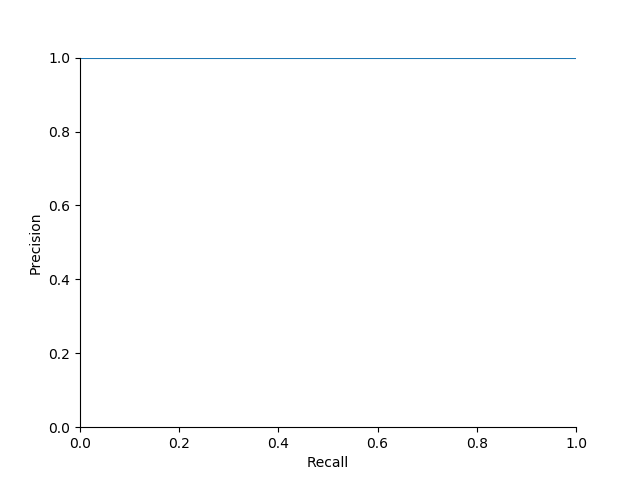

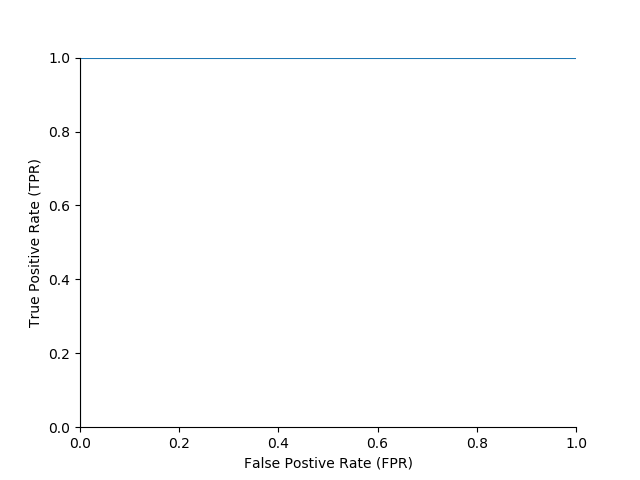

In [11]:
display_pr_roc_curves(model_dir, 'ood-eval', UncertaintyMeasuresEnum.CONFIDENCE)

In [14]:
# VGG6 Model's evaluation results for ood detect task
with open(f'{model_dir}/ood-eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 4.020999908447266 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 66.7
AUROC using distributional_uncertainty: 100.0
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



## Misclassification Detection - confidence

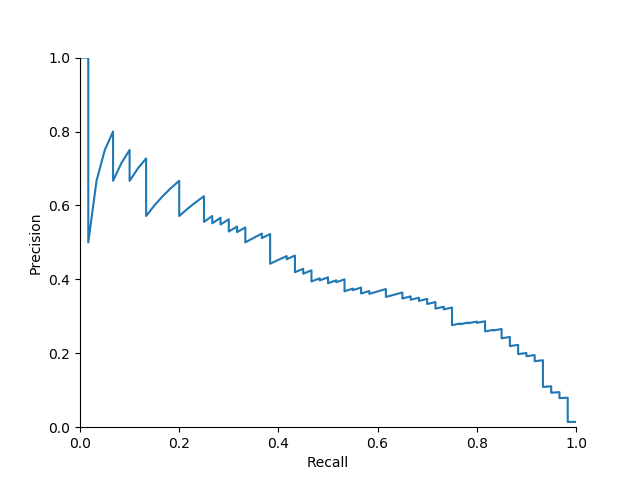

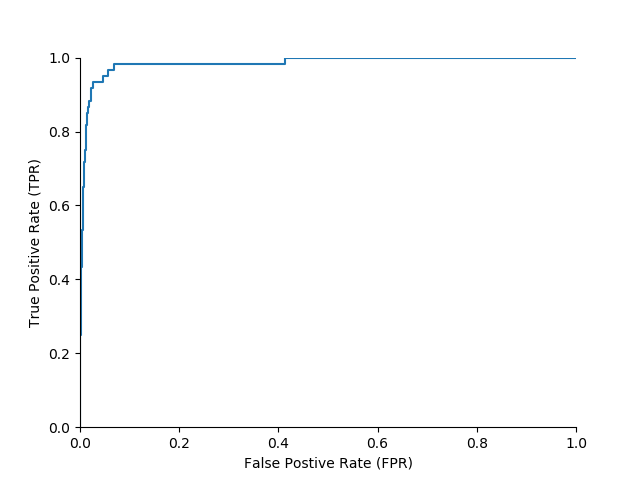

In [12]:
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

In [13]:
# VGG6 Model's evaluation results for misclassification task
with open(f'{model_dir}/eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 4.020999908447266 
AUPR using confidence: 43.1
AUROC using confidence: 98.5
AUPR using total_uncertainty: 35.0
AUROC using total_uncertainty: 98.3
AUPR using expected_data_uncertainty: 36.0
AUROC using expected_data_uncertainty: 98.4
AUPR using distributional_uncertainty: 29.3
AUROC using distributional_uncertainty: 97.7
AUPR using differential_entropy: 29.2
AUROC using differential_entropy: 98.0



## Attack on confidence - test data

In [15]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))
model_dir='runtime-model-vgg6-50epochs'

### FGSM attack

In [16]:
out_dir = model_dir+"/attack-fgsm"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm


In [17]:
os.system(cmd)

0

### PGD attack

In [5]:
out_dir = model_dir+"/attack-pgd-100"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type PGD --attack_criteria confidence --epsilon {epsilons} --max_steps 100 --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type PGD --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --max_steps 100 --model_dir runtime-model-vgg6 ./runtime-data MNIST runtime-model-vgg6/attack-pgd-100


In [6]:
os.system(cmd)

2

## Attack analysis

In [18]:
from robust_priornet.utils.visualizer import plot_adv_samples

In [19]:
model_dir="runtime-model-vgg6-50epochs"

In [20]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[]):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices)

    last_batch = misclassified_samples - (misclassified_samples%10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

### FGSM attack

# Misclassified samples under attack:  344
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  336


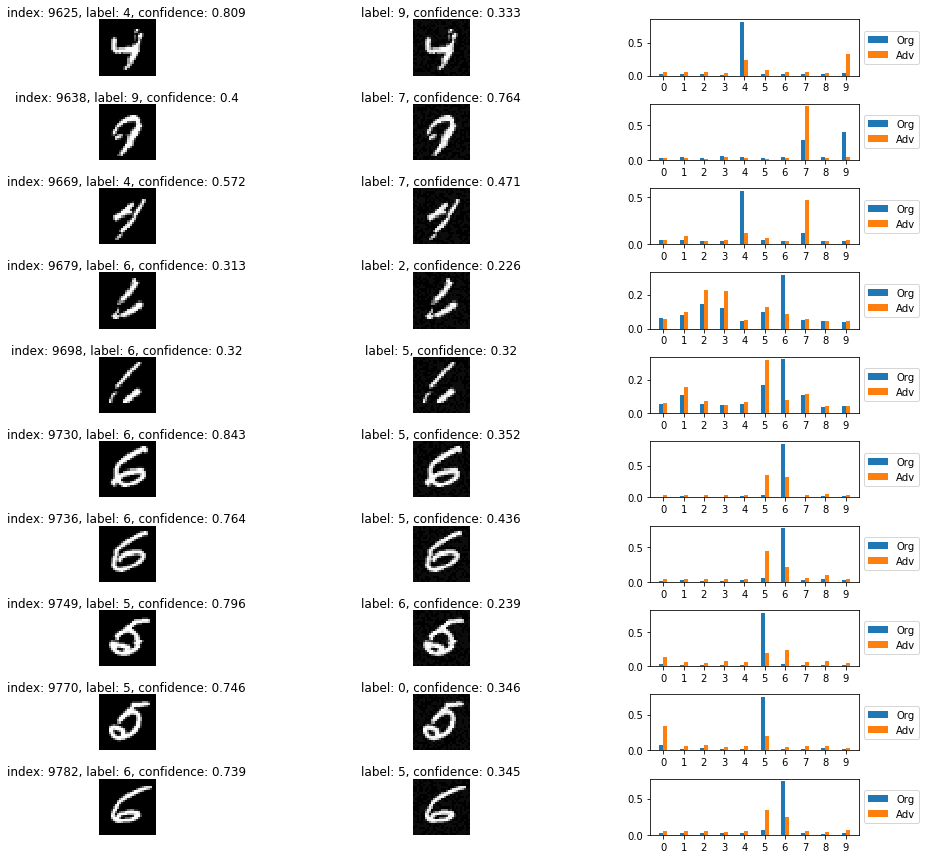

In [21]:
attack_dir=os.path.join(model_dir, "attack-fgsm")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.1)

# Misclassified samples under attack:  3923
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  3911


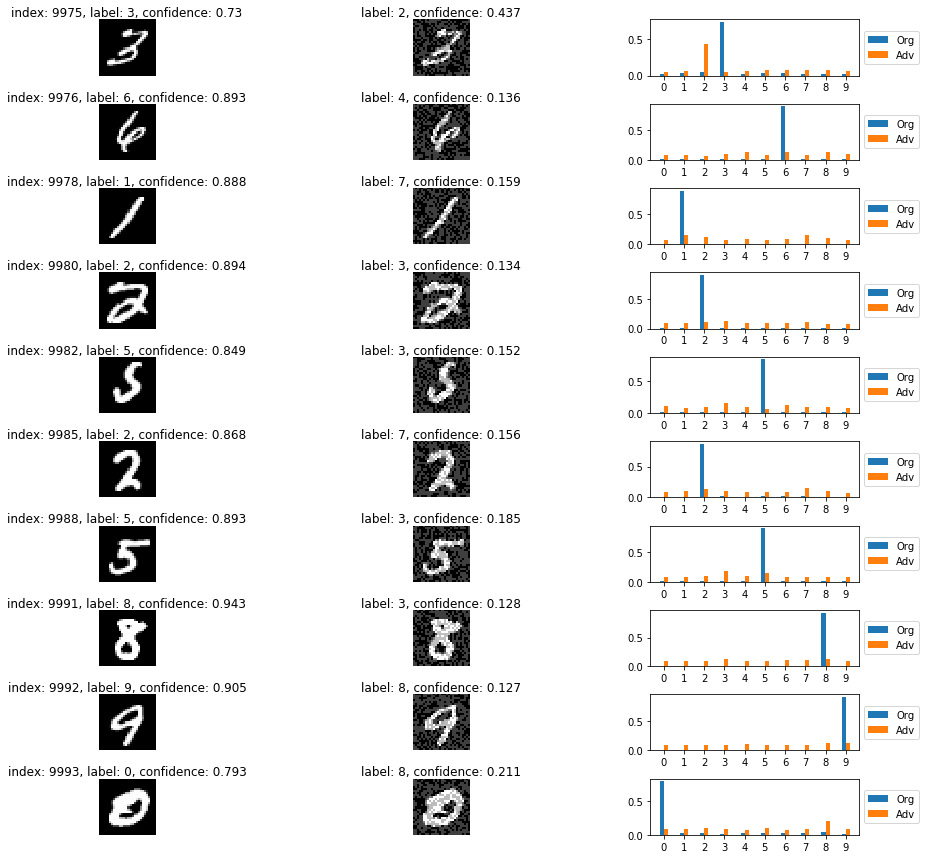

In [22]:
attack_dir=os.path.join(model_dir, "attack-fgsm")
org_eval_dir=os.path.join(model_dir, "eval")

create_vis_plots(org_eval_dir, attack_dir, 0.5)

### Epsilon vs Adversarial success rate curve

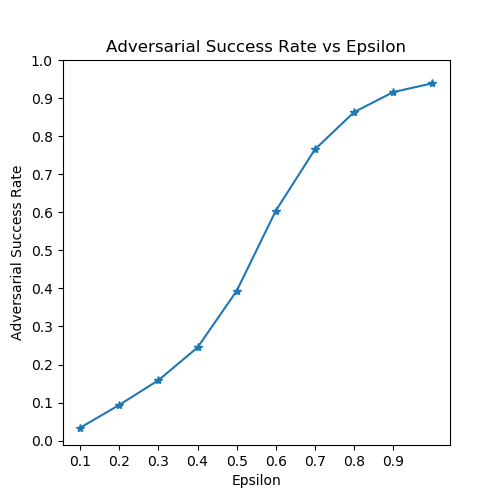

In [23]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm", "epsilon-curve.png"))
display(img)

In [15]:
# TODO: strongly misclassified images (automatically find indices)
# plot_adv_samples(model_dir, attack_dir, 0.5, plots_dir="chosen-ex", misclassified_indices=[12,35,76,95,132,157,179,258,676,2155])

In [16]:
# TODO: weakly misclassified images
# plot_adv_samples(model_dir, attack_dir, 0.5, plots_dir="chosen-ex-weak", misclassified_indices=[9, 18,1447,1427,1397,1395,1182,1119,1705,2239])

#### Model evaluation of "test set" vs "adversarial test set" on Misclassification task

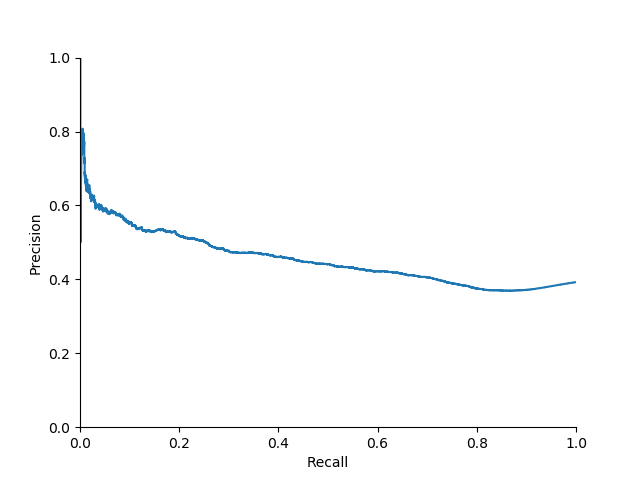

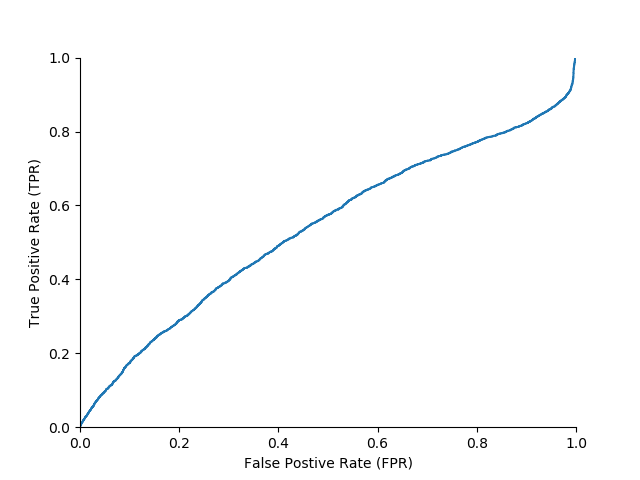

In [25]:
# model under attack
rcParams['figure.figsize'] = 5, 5
display_pr_roc_curves(model_dir, 'attack-fgsm/e0.5-attack/eval', UncertaintyMeasuresEnum.CONFIDENCE)

Results: (TODO: Update for new numbers!)
    
1) AUPR has increased from  19.6 to 43.6. (model under attack predicts more misclassifications than earlier, more positive class samples, so PR curve will improve under attack)
    
2) AUROC has declined from 86.08 to 66.9 (model under attack predicts more misclassifications than what it should as per the test data, hence ROC curve will degrade under attack)


#### Model evaluation on OOD detection task (IN:Perturbed MNIST using FGSM epsilon=0.5, OOD: OMNIGLOT)

In [ ]:
# TODO after finding threshold on train set for 

## PGD Attack on confidence - test data

In [7]:
model_dir='runtime-model-vgg6'
attack_dir=f'{model_dir}/attack-pgd-simple'

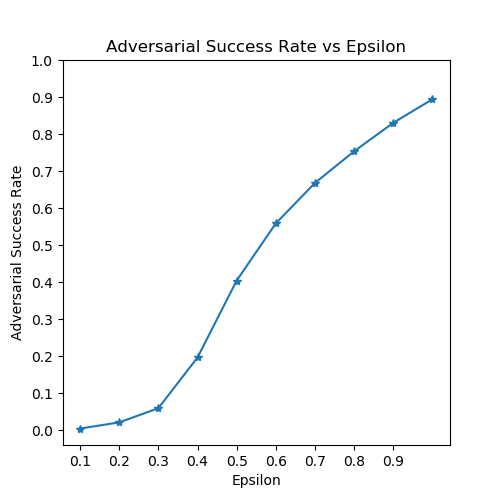

In [8]:
# sample epsilon curve
img = Image.open(f"{attack_dir}/epsilon-curve.png")
display(img)

# Misclassified samples under attack:  3085
# Real adversarial samples under attack:  3033


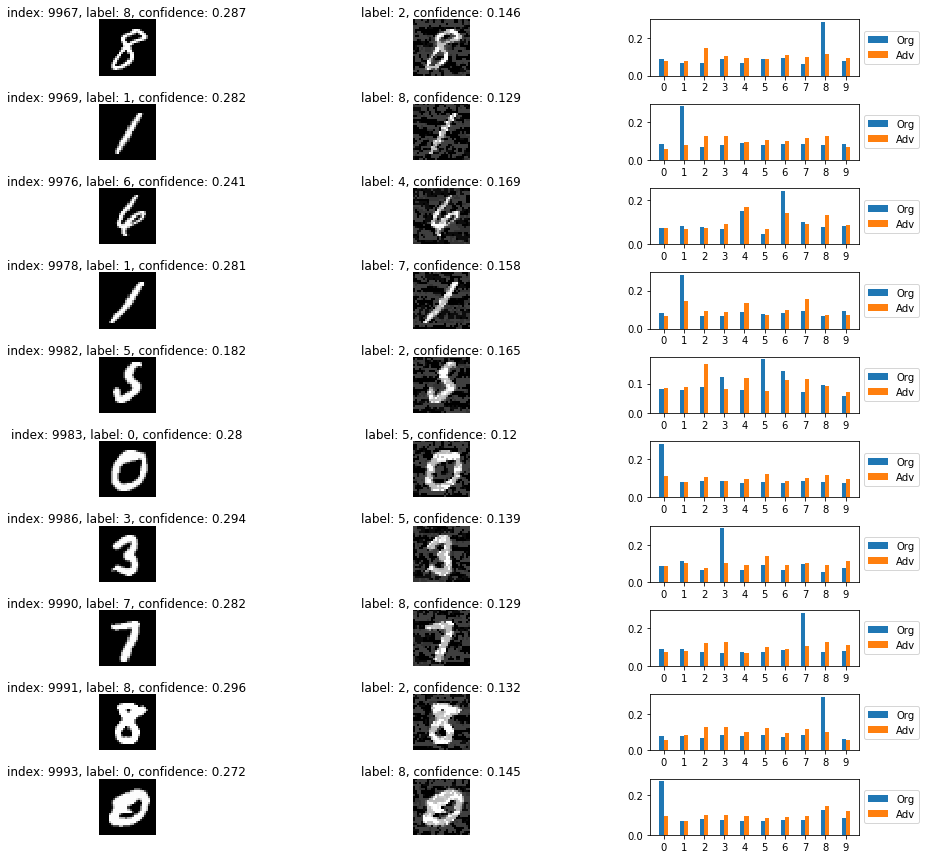

In [10]:
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.5)

#### Model evaluation of "test set" vs "perturbed test set" on Misclassification task

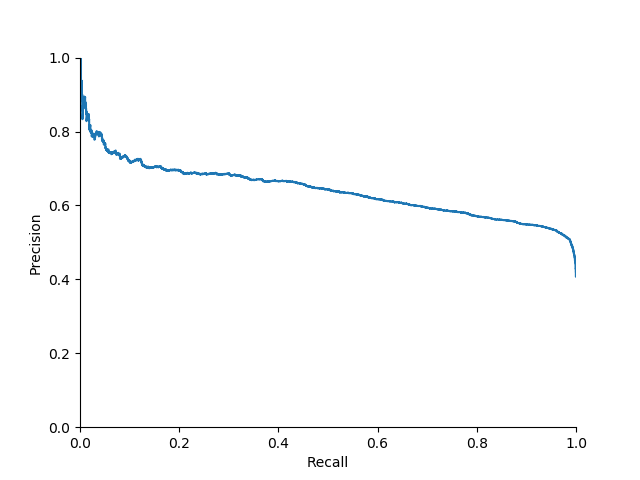

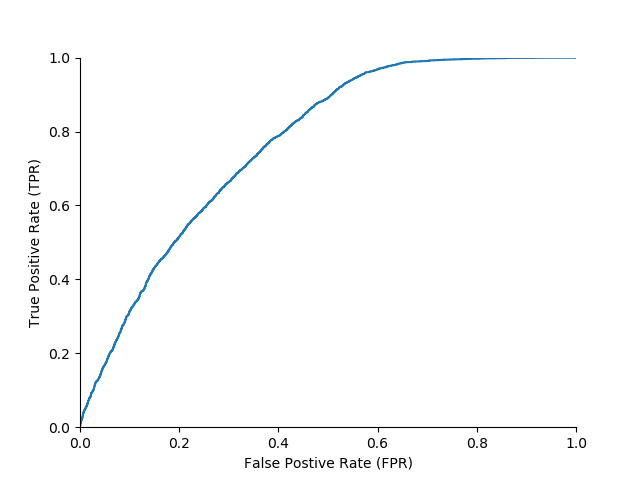

In [12]:
# model under attack
display_pr_roc_curves(model_dir, 'attack-pgd-simple/e0.5-attack/eval', UncertaintyMeasuresEnum.CONFIDENCE)

Results: (TODO: Update with new numbers!)
    
PGD proves to be a better adversary than FGSM, as ROC curve for the model under attack is brought down to almost a random classifier.

1) AUPR has increased from  19.6 to 39.9. (model under attack predicts more misclassifications than earlier, more positive class samples, so PR curve will improve under attack)

2) AUROC has declined from 86.08 to 54.7 (model under attack predicts more misclassifications than what it should as per the test data, hence ROC curve will degrade under attack)
